### Задачи:
#### Найти аэропорт с минимальной задержкой вылета 
#### Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport
#### Аэропорт с самой большой долей руления на 1 самолетовылет
#### Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика),  в зависимости от аэропорта вылета 

#### Данные - https://www.kaggle.com/usdot/flight-delays
#### Описание - Сводная информация о количестве своевременных, задержанных, отмененных и измененных рейсов в США за 2015 год (5.8 млн записей)

Бюро транспортной статистики Министерства транспорта США (DOT) отслеживает своевременность внутренних рейсов,
выполняемых крупными авиаперевозчиками. Сводная информация о количестве своевременных, задержанных, отмененных и измененных
рейсов публикуется в ежемесячном отчете DOT о пассажирских авиаперевозках и в этом наборе данных о задержках и отменах
рейсов за 2015 год.

In [3]:
%%time
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

Wall time: 0 ns


In [7]:
%%time
airlines = pd.read_csv('airlines.csv')
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv', dtype={'ORIGIN_AIRPORT': str,'DESTINATION_AIRPORT': str})

Wall time: 12.3 s


В таблице Flights поля ORIGIN_AIRPORT и DESTINATION_AIRPORT содержат много строк вместо 3-значных буквенно-цифровых кодов IATA, 5-значные числа от 10125 до 16218 которых нет справочнике Airports Для решения это проблемы  был найден справочник с числовыми кодами https://www.kaggle.com/smiller933/bts?select=L_AIRPORT_ID.csv

In [8]:
%%time
L_AIRPORT_ID = pd.read_csv('L_AIRPORT_ID.csv')
L_AIRPORT = pd.read_csv('L_AIRPORT.csv')

Wall time: 64.4 ms


### Оценка качества данных

### 1. Airlines

In [9]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


In [10]:
airlines.duplicated().sum()

0

### 2. Airports

In [11]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [12]:
airports.duplicated().sum()

0

In [13]:
airports[airports.LATITUDE.isnull()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


### 3. Flights

In [14]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [18]:
flights.YEAR.unique()

array([2015], dtype=int64)

In [19]:
flights.DIVERTED.value_counts()

0    5803892
1      15187
Name: DIVERTED, dtype: int64

In [20]:
flights.CANCELLED.value_counts()

0    5729195
1      89884
Name: CANCELLED, dtype: int64

In [21]:
flights.duplicated().sum()

0

In [22]:
for col in flights.columns:
  print(col, round(flights[col].isna().sum() / flights.shape[0] *100,2))

YEAR 0.0
MONTH 0.0
DAY 0.0
DAY_OF_WEEK 0.0
AIRLINE 0.0
FLIGHT_NUMBER 0.0
TAIL_NUMBER 0.25
ORIGIN_AIRPORT 0.0
DESTINATION_AIRPORT 0.0
SCHEDULED_DEPARTURE 0.0
DEPARTURE_TIME 1.48
DEPARTURE_DELAY 1.48
TAXI_OUT 1.53
WHEELS_OFF 1.53
SCHEDULED_TIME 0.0
ELAPSED_TIME 1.81
AIR_TIME 1.81
DISTANCE 0.0
WHEELS_ON 1.59
TAXI_IN 1.59
SCHEDULED_ARRIVAL 0.0
ARRIVAL_TIME 1.59
ARRIVAL_DELAY 1.81
DIVERTED 0.0
CANCELLED 0.0
CANCELLATION_REASON 98.46
AIR_SYSTEM_DELAY 81.72
SECURITY_DELAY 81.72
AIRLINE_DELAY 81.72
LATE_AIRCRAFT_DELAY 81.72
WEATHER_DELAY 81.72


### Резюме по анализу качества данных
    Справочник airlines (id и названия авиакомпаний) пропусков нет, дублей нет.
    Справочник airports (id название, город, штат, координаты) дублей нет, есть 3 null в полях LATITUDE, LONGITUDE, это не  критично.
    Перенаправленные рейсы (DIVERTED) - 15'187; Отмененные рейсы (CANCELLED) - 89'884.
    Таблица flights дублей нет, есть null: CANCELLATION_REASON 98.46 %; AIR_SYSTEM_DELAY 81.72 %; SECURITY_DELAY 81.72 %; AIRLINE_DELAY 81.72 %; LATE_AIRCRAFT_DELAY 81.72 %; WEATHER_DELAY 81.72 %. Большая часть из-за отмененных и отклоненных рейсов.

### Собираем dataset

В справочниках с цифровыми кодами есть дубли, на одно название аэропорта - несколько кодов. Мы не можем определить какая кодировка корректная, а какая нет. Принято решение удалять все аэропорты которые встречаются больше 1-го раза (по полю Description).

In [23]:
%%time
L_AIRPORT_copy = L_AIRPORT.copy()
L_AIRPORT_ID_copy = L_AIRPORT_ID.copy()

L_AIRPORT_copy['RN'] = L_AIRPORT_copy.sort_values(['Description'], ascending=False).groupby(['Description']).cumcount() + 1
L_AIRPORT_copy = L_AIRPORT_copy.query("RN == 1")
L_AIRPORT_copy = L_AIRPORT_copy.drop(columns=['RN'])

L_AIRPORT_ID_copy['RN'] = L_AIRPORT_ID_copy.sort_values(['Description'], ascending=False).groupby(['Description']).cumcount() + 1
L_AIRPORT_ID_copy = L_AIRPORT_ID_copy.query("RN == 1")
L_AIRPORT_ID_copy = L_AIRPORT_ID_copy.drop(columns=['RN'])

Wall time: 187 ms


Альтернативные справочники собираем единую таблицу. По полю "code_number" меням тип int64 на str для join с таблицей flights.

In [24]:
%%time
L_AIRPORT_tbl = L_AIRPORT_copy.merge(L_AIRPORT_ID_copy, how = 'inner', left_on = 'Description', right_on='Description', suffixes=('_text', '_number'))
L_AIRPORT_tbl['Code_number_2'] = L_AIRPORT_tbl['Code_number'].astype(str)

Wall time: 29 ms


Начинаем собирать итоговую таблицу "tbl".
Преобразовываем числовой код в текстовый.
Добавляем кодировки из альтернативного справочника L_AIRPORT_tbl.
Создаем 3-е поле с кодировкой аэропортов по условию. В итоге мы должны полностью избавится от числовых кодов.

In [25]:
%%time 
tbl = flights.merge(L_AIRPORT_tbl, how = 'left', left_on = 'ORIGIN_AIRPORT', right_on='Code_number_2')
tbl = tbl.merge(L_AIRPORT_tbl, how = 'left', left_on = 'DESTINATION_AIRPORT', right_on='Code_number_2', suffixes=('_orign', '_dest'))

Wall time: 14.3 s


Создаем 3-е поле с кодировкой аэропортов по условию. В итоге мы должны полностью избавится от числовых кодов.

In [26]:
%%time
tbl['Code_text_orign_1'] = np.where(tbl['Code_text_orign'].isnull(), tbl['ORIGIN_AIRPORT'], tbl['Code_text_orign'])
tbl['Code_text_dest_1'] = np.where(tbl['Code_text_dest'].isnull(), tbl['DESTINATION_AIRPORT'], tbl['Code_text_dest'])
tbl = tbl.drop(columns=['Code_text_orign', 'Code_number_orign', 'Code_number_2_orign', 'Code_text_dest', 'Code_number_dest', 'Code_number_2_dest'])

Wall time: 6.66 s


Смотрим что бы первоначальное кол-во строк не менялось.

In [27]:
%%time
print(flights.shape)
print(tbl.shape)

(5819079, 31)
(5819079, 35)
Wall time: 2 ms


Проверям остались ли цифровые коды по полю Code_text_orign_1 (код аэропорта прибытия).

In [28]:
%%time
tbl.Code_text_orign_1.unique()

Wall time: 159 ms


array(['ANC', 'LAX', 'SFO', 'SEA', 'LAS', 'DEN', 'SLC', 'PDX', 'FAI',
       'MSP', 'PHX', 'SJU', 'PBG', 'IAG', 'PSE', 'BQN', 'ORD', 'GEG',
       'HNL', 'ONT', 'MCO', 'BOS', 'HIB', 'ABR', 'MAF', 'DFW', 'MKE',
       'IAH', 'BNA', 'BRO', 'VPS', 'BOI', 'BJI', 'SGF', 'PHL', 'SBN',
       'RDD', 'EUG', 'IAD', 'BUF', 'PWM', 'JFK', 'CRP', 'PIA', 'FAT',
       'SMF', 'AUS', 'MCI', 'ATL', 'JAX', 'MFR', 'IDA', 'MSN', 'DCA',
       'SAT', 'CHS', 'SBA', 'SMX', 'IND', 'CLE', 'GSP', 'BDL', 'ABI',
       'RIC', 'BFL', 'OMA', 'RDM', 'FLL', 'CID', 'TPA', 'SYR', 'ROC',
       'TYR', 'LAN', 'XNA', 'GSO', 'EWR', 'PBI', 'RSW', 'OAK', 'PVD',
       'RNO', 'PIT', 'ABQ', 'MIA', 'BWI', 'LGA', 'TUL', 'LIT', 'MSY',
       'OKC', 'ATW', 'PNS', 'MEM', 'TYS', 'MHT', 'SAV', 'CLT', 'GRB',
       'ABE', 'JAN', 'OAJ', 'FAR', 'ERI', 'LEX', 'CWA', 'MSO', 'TTN',
       'AMA', 'CLL', 'HOU', 'JLN', 'MLI', 'RDU', 'CVG', 'MHK', 'MOB',
       'TLH', 'BHM', 'CAE', 'TXK', 'ACY', 'DTW', 'RAP', 'TUS', 'EAU',
       'DLH', 'FSD',

Остался один числовой код, его можно просто удалить (Code_text_orign_1=177 строк и Code_text_dest_1=177 строк)

In [29]:
%%time
tbl = tbl[tbl.Code_text_orign_1 != '16218']
tbl = tbl[tbl.Code_text_dest_1 != '16218']

Wall time: 2.99 s


Повторно проверям остались ли цифровые коды по полю Code_text_orign_1 (код аэропорта прибытия)

In [30]:
%%time
tbl.Code_text_orign_1.unique()

Wall time: 154 ms


array(['ANC', 'LAX', 'SFO', 'SEA', 'LAS', 'DEN', 'SLC', 'PDX', 'FAI',
       'MSP', 'PHX', 'SJU', 'PBG', 'IAG', 'PSE', 'BQN', 'ORD', 'GEG',
       'HNL', 'ONT', 'MCO', 'BOS', 'HIB', 'ABR', 'MAF', 'DFW', 'MKE',
       'IAH', 'BNA', 'BRO', 'VPS', 'BOI', 'BJI', 'SGF', 'PHL', 'SBN',
       'RDD', 'EUG', 'IAD', 'BUF', 'PWM', 'JFK', 'CRP', 'PIA', 'FAT',
       'SMF', 'AUS', 'MCI', 'ATL', 'JAX', 'MFR', 'IDA', 'MSN', 'DCA',
       'SAT', 'CHS', 'SBA', 'SMX', 'IND', 'CLE', 'GSP', 'BDL', 'ABI',
       'RIC', 'BFL', 'OMA', 'RDM', 'FLL', 'CID', 'TPA', 'SYR', 'ROC',
       'TYR', 'LAN', 'XNA', 'GSO', 'EWR', 'PBI', 'RSW', 'OAK', 'PVD',
       'RNO', 'PIT', 'ABQ', 'MIA', 'BWI', 'LGA', 'TUL', 'LIT', 'MSY',
       'OKC', 'ATW', 'PNS', 'MEM', 'TYS', 'MHT', 'SAV', 'CLT', 'GRB',
       'ABE', 'JAN', 'OAJ', 'FAR', 'ERI', 'LEX', 'CWA', 'MSO', 'TTN',
       'AMA', 'CLL', 'HOU', 'JLN', 'MLI', 'RDU', 'CVG', 'MHK', 'MOB',
       'TLH', 'BHM', 'CAE', 'TXK', 'ACY', 'DTW', 'RAP', 'TUS', 'EAU',
       'DLH', 'FSD',

К итоговой таблице "tbl" подтягиваем названия аэропортов из справочника (airports) и названия авиакомпаний (airlines). Удаляем лишние поля, переименновываем поля. 

In [31]:
%%time
tbl = tbl.merge(airports, how = 'left', left_on = 'Code_text_orign_1', right_on='IATA_CODE')
tbl = tbl.merge(airports, how = 'left', left_on = 'Code_text_dest_1', right_on='IATA_CODE', suffixes=('_orign', '_dest'))

tbl = tbl.merge(airlines, how = 'left', left_on = 'AIRLINE', right_on='IATA_CODE', suffixes=('_left', '_right'))

tbl = tbl.drop(columns=['Description_orign' ,'Description_dest' ,'IATA_CODE_orign' ,'IATA_CODE_dest' ,'IATA_CODE'])
tbl = tbl.rename (columns = {'AIRLINE_left':'AIRLINE_code', 'AIRLINE_right' : 'AIRLINE_name'})

Wall time: 25.5 s


In [32]:
%%time
tbl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5818725 entries, 0 to 5818724
Data columns (total 46 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE_code         object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

Проверяем поля с кодировкой и названиями аэропортов на null

In [33]:
%%time
tbl[['Code_text_orign_1', 'Code_text_dest_1', 'AIRPORT_orign', 'AIRPORT_dest']].isnull().sum()

Wall time: 850 ms


Code_text_orign_1    0
Code_text_dest_1     0
AIRPORT_orign        0
AIRPORT_dest         0
dtype: int64

### Задание № 1 Найти аэропорт с минимальной задержкой вылета
Смотрим только те рейсы где была задежка вылета, если вылет был раньше времени - нам это не интересно. Исключаем отмененные рейсы.

Данную задачу можно решить 2 способами: 1 по суммарному времени задерки за весь период; 2 - по среднему времени задержки на 1 рейс.

Суммарная задержка вылета сама по себе ни о чем не говорит, т.к. чем больше рейсов у аэропорта, тем больше суммарное время задержки, против аэропортов у которых небольшое кол-во рейсов. Соответственно нужно смотреть некий средний показатель.

In [35]:
%%time
task_1 = tbl.query('DEPARTURE_DELAY > 0.0 & CANCELLED == 0')
task_1 = task_1[['AIRPORT_orign', 'FLIGHT_NUMBER', 'DEPARTURE_DELAY']]
task_1 = task_1.groupby('AIRPORT_orign')\
                .agg(delay_time = pd.NamedAgg(column = 'DEPARTURE_DELAY', aggfunc = 'sum'),
                    delay_mean = pd.NamedAgg(column = 'DEPARTURE_DELAY', aggfunc = 'mean')
                    )\
                .reset_index()

print('Аэропорт с минимальной задержкой вылета (по суммарному времени задержки)')
print(task_1[['AIRPORT_orign', 'delay_time', 'delay_mean']].sort_values('delay_time',ascending=True).head(1))
print('                                                                                               ')
print('Аэропорт с минимальной задержкой вылета (по сред времени задержки на 1 рейс)')
print(task_1[['AIRPORT_orign', 'delay_time', 'delay_mean']].sort_values('delay_mean',ascending=True).head(1))

Аэропорт с минимальной задержкой вылета (по суммарному времени задержки)
        AIRPORT_orign  delay_time  delay_mean
42  Canyonlands Field       263.0   23.909091
                                                                                               
Аэропорт с минимальной задержкой вылета (по сред времени задержки на 1 рейс)
           AIRPORT_orign  delay_time  delay_mean
155  King Salmon Airport       414.0        13.8
Wall time: 1.13 s


In [36]:
%time
df_1 = task_1[['AIRPORT_orign', 'delay_time', 'delay_mean']].sort_values('delay_time',ascending=True).head(1)
df_2 = task_1[['AIRPORT_orign', 'delay_time', 'delay_mean']].sort_values('delay_mean',ascending=True).head(1)
frames = [df_1, df_2]
result = pd.concat(frames)
result
#.set_index('AIRPORT_orign').reset_index()

Wall time: 0 ns


,AIRPORT_orign,delay_time,delay_mean
42,Canyonlands Field,263.0,23.909091
155,King Salmon Airport,414.0,13.800000


### Задание № 2 Самая пунктуальная авиакомпания на прилет в Los Angeles International Airport
Исключаем отмененные рейсы и перенаправленные рейсы и отмененные рейсы.

За целевой показатель решено взять сред по времени задержки на 1 рейс. Далее смотрим авиакомпанию у которой данный показатель максимально ближе к 0. Т.к. рейс может прибыть как с опозданием так и прилётом раньше времени, приводим к модулю - нужно для корректной сортировки.

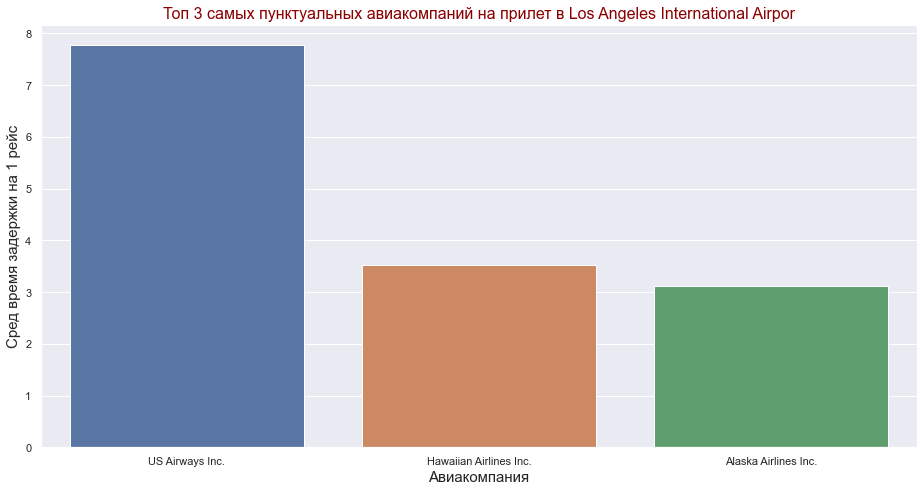

Wall time: 986 ms


In [37]:
%%time
task_2 = tbl.query("AIRPORT_dest == 'Los Angeles International Airport' & CANCELLED == 0 & DIVERTED == 0")
task_2 = task_2.groupby('AIRLINE_name')\
                .agg(delay_time = pd.NamedAgg(column = 'DEPARTURE_DELAY', aggfunc = 'sum'),
                    delay_mean = pd.NamedAgg(column = 'DEPARTURE_DELAY', aggfunc = 'mean')
                    )\
                .reset_index()

task_2['delay_mean_abs'] = task_2['delay_mean'].abs()
task_2 = task_2[['AIRLINE_name', 'delay_mean_abs']].sort_values(['delay_mean_abs'],ascending=False).tail(3)

sns.set(rc = {'figure.figsize':(13,7)})
sns.barplot(x='AIRLINE_name', y='delay_mean_abs', data = task_2)
plt.title('Топ 3 самых пунктуальных авиакомпаний на прилет в Los Angeles International Airpor' ,fontsize=16 ,loc = 'center' ,color='DarkRed')
plt.xlabel('Авиакомпания' ,fontsize = 15)
plt.ylabel('Сред время задержки на 1 рейс' ,fontsize = 15)
plt.tight_layout() 
plt.show()

### Задание № 3 Аэропорт с самой большой долей руления на 1 самолетовылет
Нам нужен аэропорт где в среднем самолёты тратят больше времени чтобы вылететь. Это показатель TAXI_OUT (доля руления = время прошедшее между отправлением от перона и взлетом) на один рейс.

Исключаем отмененные рейсы.

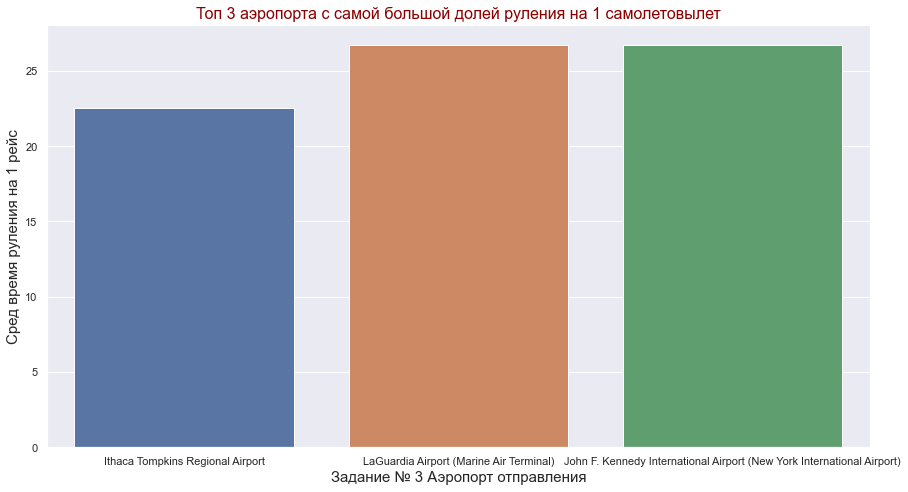

Wall time: 1.21 s


In [38]:
%%time
task_3 = tbl[['AIRPORT_orign' ,'TAXI_OUT','CANCELLED']]
task_3 = task_3.query('CANCELLED == 0')\
                .groupby('AIRPORT_orign')\
                .agg(taxi_out = pd.NamedAgg(column = 'TAXI_OUT', aggfunc = 'sum'),
                    taxi_out_mean = pd.NamedAgg(column = 'TAXI_OUT', aggfunc = 'mean')
                    )\
                .reset_index()    
task_3 = task_3[['AIRPORT_orign', 'taxi_out_mean']].sort_values('taxi_out_mean',ascending=True).tail(3)

sns.set(rc = {'figure.figsize':(13,7)})
sns.barplot(x='AIRPORT_orign', y='taxi_out_mean', data = task_3)
plt.title('Топ 3 аэропорта с самой большой долей руления на 1 самолетовылет' ,fontsize=16 ,loc = 'center' ,color='DarkRed')
plt.xlabel('Задание № 3 Аэропорт отправления' ,fontsize = 15)
plt.ylabel('Сред время руления на 1 рейс' ,fontsize = 15)
plt.tight_layout() 
plt.show()

### Задание № 4 Построить модель которая будет выбирать топ 3 аэропорта прилета (вероятность опоздания минимальная – RMSE метрика),  в зависимости от аэропорта вылета
Исключаем отмененные рейсы и перенаправленные рейсы и отмененные рейсы. Из полей YEAR MONTH DAY собираем дату.

In [39]:
%%time
task_4 = tbl.copy()
task_4 = task_4[['YEAR', 'MONTH', 'DAY', 'AIRPORT_orign', 'AIRPORT_dest', 'ARRIVAL_DELAY', 'CANCELLED' ,'DIVERTED']]            
task_4 = task_4.query('CANCELLED == 0 & DIVERTED == 0')

task_4['period_dt'] = task_4['YEAR'].astype(str) + '-' + task_4['MONTH'].astype(str) + '-' + task_4['DAY'].astype(str)
task_4['period_dt'] = pd.to_datetime(task_4.period_dt)
task_4 = task_4.drop(columns=['CANCELLED' ,'DIVERTED' ,'YEAR' ,'MONTH' ,'DAY'])
task_4 = task_4.sort_values(['AIRPORT_orign', 'AIRPORT_dest','ARRIVAL_DELAY', 'period_dt'],ascending=[True, True, True, True])

f_gr = task_4.groupby(['period_dt', 'AIRPORT_dest'], as_index=False).agg({'ARRIVAL_DELAY':'sum'})

Wall time: 19.2 s


In [30]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.period_dt.dt.year
    data['month'] = data.period_dt.dt.month
    data['day'] = data.period_dt.dt.day
    data['dayofweek'] = data.period_dt.dt.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['ARRIVAL_DELAY'].shift(lag)

Считаем сред задержку прибытия в прошлом (история за 21 день сглаженная за 7 дней)

In [31]:
%%time
where_to_go = []
for dest in f_gr.AIRPORT_dest.unique():
    tempo = f_gr[f_gr.AIRPORT_dest==dest][['period_dt','ARRIVAL_DELAY']]
    tempo.columns = ['period_dt','ARRIVAL_DELAY']
    tempo = pd.DataFrame(tempo)
    
    try:
    
        make_features(tempo,21,7)
        tempo.dropna(inplace=True)
        tempo.set_index('period_dt',inplace=True)
           
        X_train,X_test,y_train, y_test = train_test_split(tempo.drop('ARRIVAL_DELAY', axis=1),tempo.ARRIVAL_DELAY, shuffle=False, test_size=0.25)

        model_lr = LinearRegression()
        model_lr.fit(X_train,y_train)

        y_predicted_lr = model_lr.predict(X_test)
        where_to_go.append([dest,y_test.mean(),np.sqrt(mean_squared_error(y_test, y_predicted_lr))])

    except Exception as e:
        print('Error', str(e))

Error With n_samples=1, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
Wall time: 35.4 s


In [32]:
%%time
where_to_go = pd.DataFrame(where_to_go)
where_to_go.columns = ['AIRPORT_dest','MEAN_ARRIVAL_DELAY_IN_PAST','RMSE']

Wall time: 1.99 ms


Задаём рандомный аэропорт отправления (start_airport). Смотрим куда можем улететь (where_to_go_from_start_airport) из случ выбранного аэропорта отправления.
Подтягиваем к случ аэропорту вылета все аэропорты куда может улететь и смотрим сред задержку прибытия в прошлом. Выбираем мин топ 3.

In [33]:
%%time
start_airport = np.random.choice(task_4['AIRPORT_orign'].unique()) 
where_to_go_from_start_airport = task_4[task_4.AIRPORT_orign==start_airport]['AIRPORT_dest'].unique()

where_to_go_from_start_airport = pd.DataFrame(where_to_go_from_start_airport)
where_to_go_from_start_airport.columns = ['AIRPORT_dest']

top3 = where_to_go_from_start_airport\
    .merge(where_to_go,on='AIRPORT_dest',how='inner')\
    .sort_values(by=['RMSE','MEAN_ARRIVAL_DELAY_IN_PAST'],ascending=[True, True])\
    .head(3)

print('Лучшие направления с аэропорта',start_airport)
print('')
print(top3)

Лучшие направления с аэропорта Palm Springs International Airport

                            AIRPORT_dest  MEAN_ARRIVAL_DELAY_IN_PAST  \
8         Portland International Airport                   26.500000   
9   Salt Lake City International Airport                  120.558140   
11  Seattle-Tacoma International Airport                  472.732558   

           RMSE  
8    880.105329  
9   1722.417926  
11  2060.833323  
Wall time: 2 s


#### Описание полей

In [ ]:
#   0   YEAR                 int64  Year of the Flight Trip
#   1   MONTH                int64  Month of the Flight Trip
#   2   DAY                  int64  Day of the Flight Trip
#   3   DAY_OF_WEEK          int64  Day of week of the Flight Trip

#   4   AIRLINE              object Airline Identifier (Идентификатор авиакомпании)
#   5   FLIGHT_NUMBER        int64  Flight Identifier (номер рейса)
#   6   TAIL_NUMBER          object Aircraft Identifier (Идентификатор самолета)
#   7   ORIGIN_AIRPORT       object Starting Airport (id аэропорта вылета)
#   8   DESTINATION_AIRPORT  object Destination Airport (id аэропорта прилёта)

#   9   SCHEDULED_DEPARTURE  int64  Planned Departure Time (Запланированное время отправления)
#  10  DEPARTURE_TIME       float64 WHEEL_OFF - TAXI_OUT (ВРЕМЯ ОТПРАВЛЕНИЯ фактическое ???)
#  11  DEPARTURE_DELAY      float64 Total Delay on Departure (ЗАДЕРЖКА ВЫЛЕТА)

#  12  TAXI_OUT             float64 (wheels_off - departure_time) The time duration elapsed between departure from the origin airport gate and wheels off
#                       (Время, прошедшее между отправлением от выхода на посадку в аэропорту отправления и взлетом)

#  13  WHEELS_OFF           float64 The time point that the aircraft's wheels leave the ground (Веменя взлетаета)
#  14  SCHEDULED_TIME       float64 Planned time amount needed for the flight trip (плановое время полёта)
#  15  ELAPSED_TIME         float64 (AIR_TIME + TAXI_IN + TAXI_OUT) (пройденное время)
#  16  AIR_TIME             float64 (wheels_on - wheels_off) The time duration between wheels_off and wheels_on time (Продолжительность между взлётом и посадкой)
#  17  DISTANCE             int64   Distance between two airports (Расстояние между двумя аэропортами)
#  18  WHEELS_ON            float64 The time point that the aircraft's wheels touch on the ground
#                           (Момент времени, когда колеса самолета касаются земли)
#  19  TAXI_IN              float64 (arrival_time - wheels_on) The time duration elapsed between wheels-on and gate arrival at the destination airport
#                           (Время, прошедшее между посадкой и прибытием к Gate в аэропорту назначения)
#  20  SCHEDULED_ARRIVAL    int64   Planned arrival time (Планируемое время прибытия)
#  21  ARRIVAL_TIME         float64 WHEELS_ON+TAXI_IN (ВРЕМЯ ПРИБЫТИЯ, фактическое ???)
#  22  ARRIVAL_DELAY        float64 ARRIVAL_TIME-SCHEDULED_ARRIVAL (ЗАДЕРЖКА ПРИБЫТИЯ)
#  23  DIVERTED             int64   Aircraft landed on airport that out of schedule. Отклоненный рейс
#                           (Самолет приземлился в аэропорту не по расписанию)
#  24  CANCELLED            int64   Flight Cancelled (1 = cancelled) (Рейс отменен)
#  25  CANCELLATION_REASON  object  Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security
#        (Причина отмены рейса: A - Авиакомпания/Перевозчик; Б - Погода; C - Национальная воздушная система; Д - Безопасность)
#  26  AIR_SYSTEM_DELAY     float64 Delay caused by air system (Задержка из-за воздушной системы)
#  27  SECURITY_DELAY       float64 Delay caused by security (Задержка из-за безопасности)
#  28  AIRLINE_DELAY        float64 Delay caused by the airline (Задержка по вине авиакомпании)
#  29  LATE_AIRCRAFT_DELAY  float64 Delay caused by aircraft (Задержка из-за самолета)
#  30  WEATHER_DELAY        float64 Delay caused by weather (Задержка из-за погоды)

# taxi_out = wheels_off - departure_time. Время взлёта - отправление из аэропорта вылета
# taxi_in = arrival_time - wheels_on
# air_time = wheels_on - wheels_off
# elapsed_time =air_time + taxi_in + taxi_out

# Data Relationship
# arrival_time = wheels_on + taxi_in
# arrival_delay = arrival_time - scheduled_arrival
# departure_time = wheels_off - taxi_out
# departure_delay = departure_time - scheduled_departure
# elapsed_time =air_time + taxi_in + taxi_out
# air_time = wheels_on - wheels_off
#=====================================================================================================================
# Data Definition
# WHEELS_OFF Time - The time point that the aircraft's wheels leave the ground (момент времени, когда колеса самолета отрываются от земли)
# WHEELS_ON Time - The time point that the aircraft's wheels touch on the ground (момент времени, когда колеса самолета касаются земли)
# TAXI_OUT Time - The time duration elapsed between departure from the origin airport gate and wheels off (время, прошедшее с момента отправления от выхода на посадку в аэропорту отправления до выключения колес)
# TAXI_IN Time - The time duration elapsed between wheels-on and gate arrival at the destination airport (время, прошедшее между включением колес и прибытием на посадку в аэропорту назначения)
# AIR_TIME - The time duration between wheels_off and wheels_on time (время между выключением и включением колес)
#=====================================================================================================================
# Data Format
# The following times are in the xx:yy - hour:minute format (e.g. 1536 means 3:36pm, 345 means 3:45am, 16 means 00:16am)

# scheduled_departure
# departure_time
# scheduled_arrival
# arrival_time
# wheels_off
# wheels_on - The following times are in minutes format (negatives mean actual_time is ahead of scheduled_time for the absolute value of that negative number)
#       Следующие значения времени указаны в формате минут (отрицательные значения означают, что фактическое_время опережает запланированное_время для абсолютного значения этого отрицательного числа)
# arrival_delay
# departure_delay
# taxi_in
# taxi_out
# scheduled_time
# elapsed_time
# air_time - Distance in miles
#=====================================================================================================================
# WHEELS_OFF + AIR_TIME (+/- time zone!) = WHEEL_ON
# SCHEDULED_ARRIVAL - SCHEDULED_DEPARTURE (+/- time zone) = SCHEDULED_TIME
# ARRIVAL_TIME - DEPARTURE_TIME (+/- time zone) = ELAPSED TIME